## Using Siphon to query the NetCDF Subset Service

First we construct a TDSCatalog instance pointing to our dataset of interest, in
this case TDS' "Best" virtual dataset for the GFS global 0.5 degree collection of
GRIB files. We see this catalog contains a single dataset.

In [1]:
from siphon.catalog import TDSCatalog
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p5deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p5deg/Best')
best_gfs.datasets

{'Best GFS Half Degree Forecast Time Series': <siphon.catalog.Dataset at 0x108cbde10>}

We pull out this dataset and look at the access urls.

In [2]:
best_ds = list(best_gfs.datasets.values())[0]
best_ds.access_urls

{'CdmRemote': 'http://thredds.ucar.edu/thredds/cdmremote/grib/NCEP/GFS/Global_0p5deg/Best',
 'ISO': 'http://thredds.ucar.edu/thredds/iso/grib/NCEP/GFS/Global_0p5deg/Best',
 'NCML': 'http://thredds.ucar.edu/thredds/ncml/grib/NCEP/GFS/Global_0p5deg/Best',
 'NetcdfSubset': 'http://thredds.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p5deg/Best',
 'OPENDAP': 'http://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p5deg/Best',
 'UDDC': 'http://thredds.ucar.edu/thredds/uddc/grib/NCEP/GFS/Global_0p5deg/Best',
 'WCS': 'http://thredds.ucar.edu/thredds/wcs/grib/NCEP/GFS/Global_0p5deg/Best',
 'WMS': 'http://thredds.ucar.edu/thredds/wms/grib/NCEP/GFS/Global_0p5deg/Best'}

Note the `NetcdfSubset` entry, which we will use with our NCSS class.

In [3]:
from siphon.ncss import NCSS
ncss = NCSS(best_ds.access_urls['NetcdfSubset'])

We can then use the `ncss` object to create a new query object, which
facilitates asking for data from the server.

In [4]:
query = ncss.query()

We construct a query asking for data corresponding to latitude 40N and longitude 105W, for the current time.
We also ask for NetCDF version 4 data, for the variables 'Temperature_isobaric' and 'Relative_humidity_isobaric'. This request will return all vertical levels for a single point and single time. Note the string representation of the query is a properly encoded query string.

In [5]:
from datetime import datetime
query.lonlat_point(-105, 40).time(datetime.utcnow())
query.accept('netcdf4')
query.variables('Temperature_isobaric', 'Relative_humidity_isobaric')

var=Temperature_isobaric&var=Relative_humidity_isobaric&time=2015-06-17T16%3A48%3A36.440540&longitude=-105&latitude=40&accept=netcdf4

We now request data from the server using this query. The `NCSS` class handles parsing this NetCDF data (using the `netCDF4` module). If we print out the variable names, we see our requested variables, as well as a few others (more metadata information)

In [6]:
data = ncss.get_data(query)
list(data.variables.keys())

['isobaric3',
 'Temperature_isobaric',
 'Relative_humidity_isobaric',
 'station_name',
 'station_description',
 'latitude',
 'longitude',
 'time']

We'll pull out the variables we want to use, as well as the pressure values (from the `isobaric3` variable).

In [7]:
temp = data.variables['Temperature_isobaric']
relh = data.variables['Relative_humidity_isobaric']
press = data.variables['isobaric3']
press_vals = press[:].squeeze()

Now we can plot these up using matplotlib.

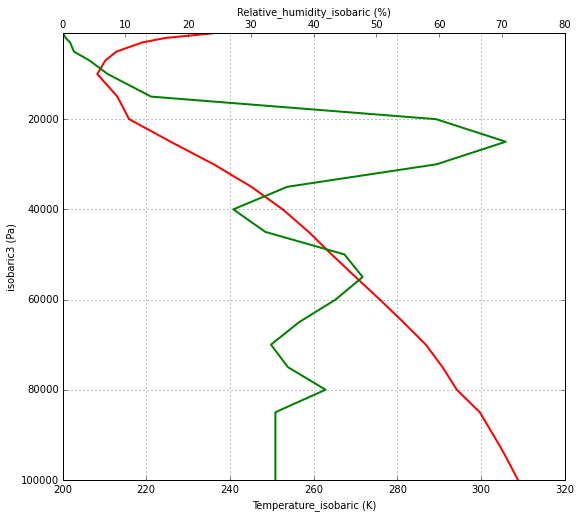

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(9, 8))
ax.plot(temp[:].squeeze(), press_vals, 'r', linewidth=2)
ax.set_xlabel(temp.standard_name + ' (%s)' % temp.units)
ax.set_ylabel(press.standard_name + ' (%s)' % press.units)

# Create second plot with shared y-axis
ax2 = plt.twiny(ax)
ax2.plot(relh[:].squeeze(), press_vals, 'g', linewidth=2)
ax2.set_xlabel(relh.standard_name + ' (%s)' % relh.units)
ax.set_ylim(press_vals.max(), press_vals.min())
ax.grid(True)